USER OVERVIEW ANALYSIS

Connecting to database

In [1]:
import pandas as pd
import math
import sys, os
from sqlalchemy import create_engine

database_name = 'telecom'
table_name= 'xdr_data'

connection_params = { "host": "localhost", "user": "postgres", "password": "postgres",
                    "port": "5000", "database": database_name}

engine = create_engine(f"postgresql+psycopg2://{connection_params['user']}:{connection_params['password']}@{connection_params['host']}:{connection_params['port']}/{connection_params['database']}")

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from cleaner import *
from helper import *
from plot import *
from outlier_handler import OutlierHandler

Read and explore the dataset 

In [3]:
# str or SQLAlchemy Selectable (select or text object)
sql_query = 'SELECT * FROM xdr_data'

df = pd.read_sql(sql_query, con= engine)
# Display the first few rows of the dataset
print(df.head(5))

# Get information about the dataset
print(df.info())

# Summary statistics of numerical columns
print(df.describe())


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

Identify Missing Values

In [4]:
# Count missing values in each column
missing_values_count = df.isnull().sum()

Cleaninig Data

In [5]:
import numpy as np

# Calculate total number of cells in dataframe
totalCells = np.product(df.shape)

# Count number of missing values per column
missingCount = df.isnull().sum()

# Calculate total number of missing values
totalMissing = missingCount.sum()

print("The total cells contains",totalCells)
print("The missing  count is",totalMissing)

# Calculate percentage of missing values
print("The dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")


The total cells contains 8250055
The missing  count is 1031392
The dataset contains 12.5 % missing values.


In [6]:
# Calculate the percentage of missing values for each column
missing_percentages = (df.isna().mean() * 100).round(2)

# Display the result
print("Percentage of missing values in each column:")
print(missing_percentages)

Percentage of missing values in each column:
Bearer Id                                    0.66
Start                                        0.00
Start ms                                     0.00
End                                          0.00
End ms                                       0.00
Dur. (ms)                                    0.00
IMSI                                         0.38
MSISDN/Number                                0.71
IMEI                                         0.38
Last Location Name                           0.77
Avg RTT DL (ms)                             18.55
Avg RTT UL (ms)                             18.54
Avg Bearer TP DL (kbps)                      0.00
Avg Bearer TP UL (kbps)                      0.00
TCP DL Retrans. Vol (Bytes)                 58.76
TCP UL Retrans. Vol (Bytes)                 64.43
DL TP < 50 Kbps (%)                          0.50
50 Kbps < DL TP < 250 Kbps (%)               0.50
250 Kbps < DL TP < 1 Mbps (%)                0.50
DL TP

In [7]:
#drop columns with more than 30% missing values
df_clean = df.drop(['Nb of sec with 37500B < Vol UL',
 'Nb of sec with 6250B < Vol UL < 37500B',
 'Nb of sec with 125000B < Vol DL',
 'Nb of sec with 31250B < Vol DL < 125000B',
 'Nb of sec with 1250B < Vol UL < 6250B',
 'Nb of sec with 6250B < Vol DL < 31250B',
 'HTTP UL (Bytes)',
 'HTTP DL (Bytes)'], axis=1)
df_clean.shape

(150001, 47)

In [8]:
df_clean.isna().sum()

Bearer Id                           991
Start                                 1
Start ms                              1
End                                   1
End ms                                1
Dur. (ms)                             1
IMSI                                570
MSISDN/Number                      1066
IMEI                                572
Last Location Name                 1153
Avg RTT DL (ms)                   27829
Avg RTT UL (ms)                   27812
Avg Bearer TP DL (kbps)               1
Avg Bearer TP UL (kbps)               1
TCP DL Retrans. Vol (Bytes)       88146
TCP UL Retrans. Vol (Bytes)       96649
DL TP < 50 Kbps (%)                 754
50 Kbps < DL TP < 250 Kbps (%)      754
250 Kbps < DL TP < 1 Mbps (%)       754
DL TP > 1 Mbps (%)                  754
UL TP < 10 Kbps (%)                 792
10 Kbps < UL TP < 50 Kbps (%)       792
50 Kbps < UL TP < 300 Kbps (%)      792
UL TP > 300 Kbps (%)                792
Activity Duration DL (ms)             1


Since the missing value for TCP DL Retrans. Vol (Bytes) and TCP UL Retrans. Vol (Bytes) is very high we use backwardfill

In [9]:
fix_missing_bfill(df_clean, 'TCP DL Retrans. Vol (Bytes)')

88146 missing values in the column TCP DL Retrans. Vol (Bytes) have been replaced using the backward fill method.


d:\week-1\Telecom_DataAnalysis\scripts\cleaner.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill')


0         19520.0
1         19520.0
2         19520.0
3         19520.0
4         19520.0
           ...   
149996        NaN
149997        NaN
149998        NaN
149999        NaN
150000        NaN
Name: TCP DL Retrans. Vol (Bytes), Length: 150001, dtype: float64

In [10]:
fix_missing_bfill(df_clean, 'TCP UL Retrans. Vol (Bytes)')

96649 missing values in the column TCP UL Retrans. Vol (Bytes) have been replaced using the backward fill method.


0         7230.0
1         7230.0
2         7230.0
3         7230.0
4         7230.0
           ...  
149996       NaN
149997       NaN
149998       NaN
149999       NaN
150000       NaN
Name: TCP UL Retrans. Vol (Bytes), Length: 150001, dtype: float64

we use forward fill for the next high missing values which are Avg RTT DL (ms) and Avg RTT UL (ms) 

In [11]:
fix_missing_ffill(df_clean, 'Avg RTT DL (ms)')

27829 missing values in the column Avg RTT DL (ms) have been replaced using the forward fill method.


d:\week-1\Telecom_DataAnalysis\scripts\cleaner.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill')


0         42.0
1         65.0
2         65.0
3         65.0
4         65.0
          ... 
149996    32.0
149997    27.0
149998    43.0
149999    37.0
150000    37.0
Name: Avg RTT DL (ms), Length: 150001, dtype: float64

In [12]:
fix_missing_ffill(df_clean, 'Avg RTT UL (ms)')

27812 missing values in the column Avg RTT UL (ms) have been replaced using the forward fill method.


0         5.0
1         5.0
2         5.0
3         5.0
4         5.0
         ... 
149996    0.0
149997    2.0
149998    6.0
149999    5.0
150000    5.0
Name: Avg RTT UL (ms), Length: 150001, dtype: float64

Checking the missing values in the new cleaned data

In [13]:
percent_missing_values(df_clean)

The dataset contains 0.19 % missing values.


C:\Users\Dell6\AppData\Local\Temp\ipykernel_18608\988583864.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  percent_missing_values(df_clean)


Since Handset Type and Handset Manufacturer are categorical columns, it is better to impute them with the value "unknown" so that we don't bias the data.

In [14]:
fix_missing_value(df_clean, 'Handset Type', 'unknown')
fix_missing_value(df_clean, 'Handset Manufacturer', 'unknown')

572 missing values in the column Handset Type have been replaced by unknown.
572 missing values in the column Handset Manufacturer have been replaced by unknown.


0           Samsung
1           Samsung
2           Samsung
3         undefined
4           Samsung
            ...    
149996        Apple
149997        Apple
149998        Apple
149999       Huawei
150000      unknown
Name: Handset Manufacturer, Length: 150001, dtype: object

In [15]:
percent_missing_values(df_clean)

The dataset contains 0.17 % missing values.


C:\Users\Dell6\AppData\Local\Temp\ipykernel_18608\988583864.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  percent_missing_values(df_clean)


In [16]:
percent_missing_rows(df_clean)

2.08 % of the rows in the dataset contain atleast one missing value.


Then we will drop the missing rows

In [17]:
drop_rows_with_missing_values(df_clean)

3114 rows containg missing values were dropped.


In [18]:
percent_missing_values(df_clean)

The dataset contains 0.0 % missing values.


C:\Users\Dell6\AppData\Local\Temp\ipykernel_18608\988583864.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  percent_missing_values(df_clean)


DATA TYPE CONVERTION

In [19]:
df_clean.dtypes

Bearer Id                         float64
Start                              object
Start ms                          float64
End                                object
End ms                            float64
Dur. (ms)                         float64
IMSI                              float64
MSISDN/Number                     float64
IMEI                              float64
Last Location Name                 object
Avg RTT DL (ms)                   float64
Avg RTT UL (ms)                   float64
Avg Bearer TP DL (kbps)           float64
Avg Bearer TP UL (kbps)           float64
TCP DL Retrans. Vol (Bytes)       float64
TCP UL Retrans. Vol (Bytes)       float64
DL TP < 50 Kbps (%)               float64
50 Kbps < DL TP < 250 Kbps (%)    float64
250 Kbps < DL TP < 1 Mbps (%)     float64
DL TP > 1 Mbps (%)                float64
UL TP < 10 Kbps (%)               float64
10 Kbps < UL TP < 50 Kbps (%)     float64
50 Kbps < UL TP < 300 Kbps (%)    float64
UL TP > 300 Kbps (%)              

In [20]:
convert_to_datetime(df_clean, ['Start', 'End'])

In [21]:
string_columns = df_clean.select_dtypes(include='object').columns.tolist()
string_columns

['Last Location Name', 'Handset Manufacturer', 'Handset Type']

We will convert this object types to string

In [22]:
convert_to_string(df_clean, string_columns)

Since Bearer Id, IMSI, MSISDN/Number, IMEI are used as an id we will change them to int64

In [23]:
cols_to_int = ['Bearer Id', 'IMSI', 'MSISDN/Number', 'IMEI',]
convert_to_int(df_clean, cols_to_int)

In [24]:
df_clean.dtypes

Bearer Id                                  int64
Start                             datetime64[ns]
Start ms                                 float64
End                               datetime64[ns]
End ms                                   float64
Dur. (ms)                                float64
IMSI                                       int64
MSISDN/Number                              int64
IMEI                                       int64
Last Location Name                string[python]
Avg RTT DL (ms)                          float64
Avg RTT UL (ms)                          float64
Avg Bearer TP DL (kbps)                  float64
Avg Bearer TP UL (kbps)                  float64
TCP DL Retrans. Vol (Bytes)              float64
TCP UL Retrans. Vol (Bytes)              float64
DL TP < 50 Kbps (%)                      float64
50 Kbps < DL TP < 250 Kbps (%)           float64
250 Kbps < DL TP < 1 Mbps (%)            float64
DL TP > 1 Mbps (%)                       float64
UL TP < 10 Kbps (%) 

we will drop duplicates if any

In [25]:
drop_duplicates(df_clean)

No duplicate rows were found.


Outlier Handler

In [26]:
outlier_handler = OutlierHandler(df_clean)

In [27]:
columns = df_clean.select_dtypes('float64').columns.tolist()
outlier_handler.getOverview(columns)

Name of columns,DL TP > 1 Mbps (%),10 Kbps < UL TP < 50 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),Activity Duration DL (ms),Activity Duration UL (ms),Nb of sec with Vol UL < 1250B,Nb of sec with Vol DL < 6250B,UL TP < 10 Kbps (%),TCP DL Retrans. Vol (Bytes),Avg Bearer TP UL (kbps),...,Start ms,Youtube DL (Bytes),Email UL (Bytes),Email DL (Bytes),Google UL (Bytes),Google DL (Bytes),Social Media UL (Bytes),Social Media DL (Bytes),End ms,Total DL (Bytes)
Min,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,...,0.0,53.0,2.0,14.0,3.0,207.0,0.0,12.0,0.0,7114041.0
Q1,0.0,0.0,0.0,15418.0,22073.0,107.0,87.0,99.0,24875.0,47.0,...,250.0,5833462.0,233439.0,892573.0,1024371.5,2882586.5,16431.0,898089.0,251.0,243073402.5
Median,0.0,0.0,0.0,39726.0,47180.0,217.0,201.0,100.0,392067.0,63.0,...,499.0,11616334.0,466357.0,1793613.0,2054793.0,5766724.0,32908.0,1793409.0,500.0,455963875.0
Q3,0.0,0.0,1.0,697298.5,611803.0,2466.5,2612.5,100.0,3078146.0,1136.0,...,749.0,17440635.5,700297.5,2689818.0,3088071.5,8625551.0,49326.5,2694640.0,750.0,665783068.0
Max,94.0,98.0,76.0,136536461.0,144911293.0,604122.0,604061.0,100.0,4294425570.0,58613.0,...,999.0,23259098.0,936418.0,3586146.0,4121357.0,11462832.0,65870.0,3586064.0,999.0,902969616.0
IQR,0.0,0.0,1.0,681880.5,589730.0,2359.5,2525.5,1.0,3053271.0,1089.0,...,499.0,11607173.5,466858.5,1797245.0,2063700.0,5742964.5,32895.5,1796551.0,499.0,422709665.5
Lower fence,0.0,0.0,-1.5,-1007402.75,-862522.0,-3432.25,-3701.25,97.5,-4555031.5,-1586.5,...,-498.5,-11577298.25,-466848.75,-1803294.5,-2071178.5,-5731860.25,-32912.25,-1796737.5,-497.5,-390991095.75
Upper fence,0.0,0.0,2.5,1720119.25,1496398.0,6005.75,6400.75,101.5,7658052.5,2769.5,...,1497.5,34851395.75,1400585.25,5385685.5,6183621.5,17239997.75,98669.75,5389466.5,1498.5,1299847566.25
Skew,5.345557,10.941071,4.503234,5.821286,7.321154,7.467915,9.009273,-8.958674,16.738824,4.473627,...,0.000823,0.000119,0.007312,-0.002659,0.002242,-0.008414,0.000258,-0.001633,-0.001251,-0.003579
Number_of_outliers,36594,31509,29343,26126,25501,24870,24604,21811,21636,21104,...,0,0,0,0,0,0,0,0,0,0


In [28]:
outlier_handler.replace_outliers_with_fences(columns)
outlier_handler.getOverview(columns)

Name of columns,Start ms,Youtube DL (Bytes),Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube UL (Bytes),...,TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),Total DL (Bytes)
Min,0.0,53.0,1.0,12.0,0.0,207.0,3.0,14.0,2.0,105.0,...,1.0,77.5,0.0,0.0,0.0,97.5,0.0,0.0,0.0,7114041.0
Q1,250.0,5833462.0,107.0,898089.0,16431.0,2882586.5,1024371.5,892573.0,233439.0,5516549.0,...,3297.0,91.0,0.0,0.0,0.0,99.0,0.0,0.0,0.0,243073402.5
Median,499.0,11616334.0,217.0,1793409.0,32908.0,5766724.0,2054793.0,1793613.0,466357.0,11013447.0,...,16402.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,455963875.0
Q3,749.0,17440635.5,2466.5,2694640.0,49326.5,8625551.0,3088071.5,2689818.0,700297.5,16514278.0,...,68727.0,100.0,4.0,1.0,0.0,100.0,0.0,0.0,0.0,665783068.0
Max,999.0,23259098.0,6005.75,3586064.0,65870.0,11462832.0,4121357.0,3586146.0,936418.0,22011962.0,...,166872.0,100.0,10.0,2.5,0.0,100.0,0.0,0.0,0.0,902969616.0
IQR,499.0,11607173.5,2359.5,1796551.0,32895.5,5742964.5,2063700.0,1797245.0,466858.5,10997729.0,...,65430.0,9.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,422709665.5
Lower fence,-498.5,-11577298.25,-3432.25,-1796737.5,-32912.25,-5731860.25,-2071178.5,-1803294.5,-466848.75,-10980044.5,...,-94848.0,77.5,-6.0,-1.5,0.0,97.5,0.0,0.0,0.0,-390991095.75
Upper fence,1497.5,34851395.75,6005.75,5389466.5,98669.75,17239997.75,6183621.5,5385685.5,1400585.25,33010871.5,...,166872.0,113.5,10.0,2.5,0.0,101.5,0.0,0.0,0.0,1299847566.25
Skew,0.000823,0.000119,1.209533,-0.001633,0.000258,-0.008414,0.002242,-0.002659,0.007312,-0.001265,...,1.203139,-1.22817,1.315047,1.098748,0.0,-0.947267,0.0,0.0,0.0,-0.003579
Number_of_outliers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# save the clean dataframe to a csv file
df_clean.to_csv('../data/clean_data.csv')

Filtering Data

In [40]:
# top_10_handsets
top_10_handsets = df_clean['Handset Type'].value_counts().head(10)
print("Top 10 Handsets:")
print(top_10_handsets)


Top 10 Handsets:
Handset Type
Huawei B528S-23A                19373
Apple iPhone 6S (A1688)          9369
Apple iPhone 6 (A1586)           8967
undefined                        8820
Apple iPhone 7 (A1778)           6240
Apple iPhone Se (A1723)          5150
Apple iPhone 8 (A1905)           4961
Apple iPhone Xr (A2105)          4542
Samsung Galaxy S8 (Sm-G950F)     4404
Apple iPhone X (A1901)           3788
Name: count, dtype: Int64


In [41]:
# top_3_handset manfacturers
top_3_handset_manfacturers = df_clean['Handset Manufacturer'].value_counts().head(3)
print("Top 3 Handset Manufacturers:")
print(top_3_handset_manfacturers)

Top 3 Handset Manufacturers:
Handset Manufacturer
Apple      59069
Samsung    39902
Huawei     33754
Name: count, dtype: Int64


In [42]:
# Aggregate usage of each handset type, grouped by manufacturer and type
usage_by_manufacturer_type = df_clean.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name='usage_count')

# Identify the top 3 handset manufacturers based on usage
top_3_manufacturers = usage_by_manufacturer_type.groupby('Handset Manufacturer')['usage_count'].sum().nlargest(3).index

# Create an empty DataFrame to store the top 5 handset types per top 3 manufacturers
top_5_per_manufacturer = pd.DataFrame(columns=['Handset Manufacturer', 'Handset Type', 'usage_count'])

# Iterate over the top 3 manufacturers
for manufacturer in top_3_manufacturers:
    # Filter usage data for the current manufacturer
    manufacturer_data = usage_by_manufacturer_type[usage_by_manufacturer_type['Handset Manufacturer'] == manufacturer]
    
    # Get the top 5 handset types used by the current manufacturer
    top_5_handset_types = manufacturer_data.nlargest(5, 'usage_count')
    
    # Concatenate the top 5 handset types to the DataFrame
    top_5_per_manufacturer = pd.concat([top_5_per_manufacturer, top_5_handset_types])

# Reset index
top_5_per_manufacturer.reset_index(drop=True, inplace=True)

# Print the top 5 handset types per top 3 manufacturers
print("Top 5 Handset Types per Top 3 Manufacturers:")
print(top_5_per_manufacturer)


Top 5 Handset Types per Top 3 Manufacturers:
   Handset Manufacturer                    Handset Type usage_count
0                 Apple         Apple iPhone 6S (A1688)        9369
1                 Apple          Apple iPhone 6 (A1586)        8967
2                 Apple          Apple iPhone 7 (A1778)        6240
3                 Apple         Apple iPhone Se (A1723)        5150
4                 Apple          Apple iPhone 8 (A1905)        4961
5               Samsung    Samsung Galaxy S8 (Sm-G950F)        4404
6               Samsung      Samsung Galaxy A5 Sm-A520F        3673
7               Samsung     Samsung Galaxy J5 (Sm-J530)        3664
8               Samsung     Samsung Galaxy J3 (Sm-J330)        3431
9               Samsung    Samsung Galaxy S7 (Sm-G930X)        3106
10               Huawei                Huawei B528S-23A       19373
11               Huawei                    Huawei E5180        2062
12               Huawei  Huawei P20 Lite Huawei Nova 3E        2000
13 

C:\Users\Dell6\AppData\Local\Temp\ipykernel_18608\4098679740.py:19: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



XDR sessions

In [43]:
#Number of Xdr sessions per user
xdr = find_agg(df_clean, 'MSISDN/Number', 'count', 'Bearer Id', False)
xdr.rename(
        columns={'Bearer Id': 'Number of xDR sessions'}, inplace=True)
xdr

,MSISDN/Number,Number of xDR sessions
0,33626320676,18
1,33625779332,17
2,33614892860,17
3,33659725664,16
4,33675877202,15
...,...,...
105711,33660669493,1
105712,33660669025,1
105713,33660668320,1
105714,33660668134,1


Session Duration

In [44]:
session_duration = df_clean.groupby('MSISDN/Number').agg({'Dur. (ms)': 'mean'})
session_duration.rename(
        columns={'Dur. (ms)': 'Average session duration (ms)'}, inplace=True)
session_duration

,Average session duration (ms)
MSISDN/Number,
33601001722,116720.00
33601001754,181230.00
33601002511,134969.00
33601007832,49878.00
33601008617,18552.00
...,...
33789967113,160461.00
33789980299,105194.50
33789996170,8810.00


Total download (DL) and upload (UL) data

In [45]:
df_clean['Total Data Volume (Bytes)'] = df_clean['Total UL (Bytes)'] + df_clean['Total DL (Bytes)']
total_data = df_clean.groupby('MSISDN/Number')[[ 'Total UL (Bytes)', 'Total DL (Bytes)','Total Data Volume (Bytes)']].sum()
total_data.nlargest(10, 'Total Data Volume (Bytes)')

,Total UL (Bytes),Total DL (Bytes),Total Data Volume (Bytes)
MSISDN/Number,,,
33614892860,689483001.0,8.156743e+09,8.846226e+09
33760536639,703478581.0,7.811295e+09,8.514774e+09
33625779332,729577380.0,7.770043e+09,8.499621e+09
33626320676,669650721.0,7.301517e+09,7.971167e+09
33675877202,581568792.0,7.309542e+09,7.891111e+09
33659725664,624260321.0,7.081602e+09,7.705863e+09
33666464084,405060976.0,6.903440e+09,7.308501e+09
33760413819,521518890.0,6.610852e+09,7.132371e+09
33664712899,471562882.0,6.400774e+09,6.872337e+09


Total data volume (in Bytes) during this session for each application

In [46]:
applications_total = df_clean.groupby('MSISDN/Number')[['Social Media DL (Bytes)','Social Media UL (Bytes)', 'Google DL (Bytes)','Google UL (Bytes)',
    'Email DL (Bytes)','Email DL (Bytes)', 'Youtube DL (Bytes)','Youtube UL (Bytes)', 'Netflix DL (Bytes)','Netflix UL (Bytes)',
    'Gaming DL (Bytes)','Gaming UL (Bytes)', 'Other DL (Bytes)','Other UL (Bytes)' ,'Total Data Volume (Bytes)']].sum()
applications_total.nlargest(10, 'Total Data Volume (Bytes)')

,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email DL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total Data Volume (Bytes)
MSISDN/Number,,,,,,,,,,,,,,,
33614892860,27749744.0,544800.0,93941708.0,34032079.0,33607211.0,33607211.0,199823443.0,194546775.0,179585986.0,181815060.0,7.622035e+09,127396833.0,7.495298e+09,143966031.0,8.846226e+09
33760536639,39297646.0,485543.0,88626532.0,34596567.0,26437895.0,26437895.0,194068298.0,202220900.0,146500839.0,188142430.0,7.316364e+09,144681056.0,4.590038e+09,126096213.0,8.514774e+09
33625779332,26564121.0,571379.0,107904739.0,34403176.0,31895412.0,31895412.0,237883033.0,215075736.0,193912238.0,163068369.0,7.171884e+09,154789688.0,6.201653e+09,152930478.0,8.499621e+09
33626320676,42743837.0,630942.0,116106455.0,36085397.0,33404785.0,33404785.0,164048706.0,210434341.0,199479238.0,129246502.0,6.745734e+09,141838597.0,8.025477e+09,142400945.0,7.971167e+09
33675877202,18655364.0,567557.0,83002994.0,26857508.0,24284723.0,24284723.0,158665235.0,158745337.0,161626462.0,147466697.0,6.863307e+09,107260559.0,6.665074e+09,133441436.0,7.891111e+09
33659725664,34900444.0,511914.0,90958549.0,25557796.0,29907647.0,29907647.0,119658146.0,138332942.0,196277206.0,203241873.0,6.609900e+09,115658741.0,6.182551e+09,134864910.0,7.705863e+09
33666464084,18234924.0,395062.0,62599213.0,26721524.0,19667181.0,19667181.0,140663858.0,86672154.0,115946985.0,98469941.0,6.546328e+09,99975537.0,4.262205e+09,86936800.0,7.308501e+09
33760413819,20515774.0,261431.0,56331853.0,26406867.0,21791296.0,21791296.0,174245981.0,128923126.0,167023809.0,151323737.0,6.170943e+09,97676681.0,3.988504e+09,113141379.0,7.132371e+09
33664712899,19035729.0,354870.0,64946017.0,25443355.0,15213560.0,15213560.0,153074482.0,123759531.0,134941569.0,116857240.0,6.013562e+09,90293610.0,3.868637e+09,108323400.0,6.872337e+09


### Univariate Analysis

Handset Manufacturer

In [47]:
#  counts unique value
counts_handset_manufacturers = df_clean['Handset Manufacturer'].value_counts()
counts_handset_manufacturers

Handset Manufacturer
Apple                                    59069
Samsung                                  39902
Huawei                                   33754
undefined                                 8820
Sony Mobile Communications Ab              925
                                         ...  
Sintave Technology (Group) Co Ltd            1
ZyXEL Communications Corp                    1
Shenzhen Sprocomm Technologies Co Ltd        1
Hewlett-Packard                              1
Shenzhen Gaoxinqi                            1
Name: count, Length: 168, dtype: Int64

In [52]:
plotly_plot_pie(df_clean, 'Handset Manufacturer', 300)

Handset Type

In [53]:
#  counts unique value
counts_handset_type = df_clean['Handset Type'].value_counts()
counts_handset_type

Handset Type
Huawei B528S-23A                             19373
Apple iPhone 6S (A1688)                       9369
Apple iPhone 6 (A1586)                        8967
undefined                                     8820
Apple iPhone 7 (A1778)                        6240
                                             ...  
Tcl Communicatio. Alcatel Pop4 6 4G 7070X        1
Lenovo Moto C                                    1
Fully Holdings (. Oukitel C2                     1
Lenovo Moto G (5Th Gen) Da12936945               1
Shenzhen Jeko Co. Blackview Bv5800 Pro           1
Name: count, Length: 1363, dtype: Int64

In [54]:
plotly_plot_pie(df_clean, 'Handset Type', 1000)

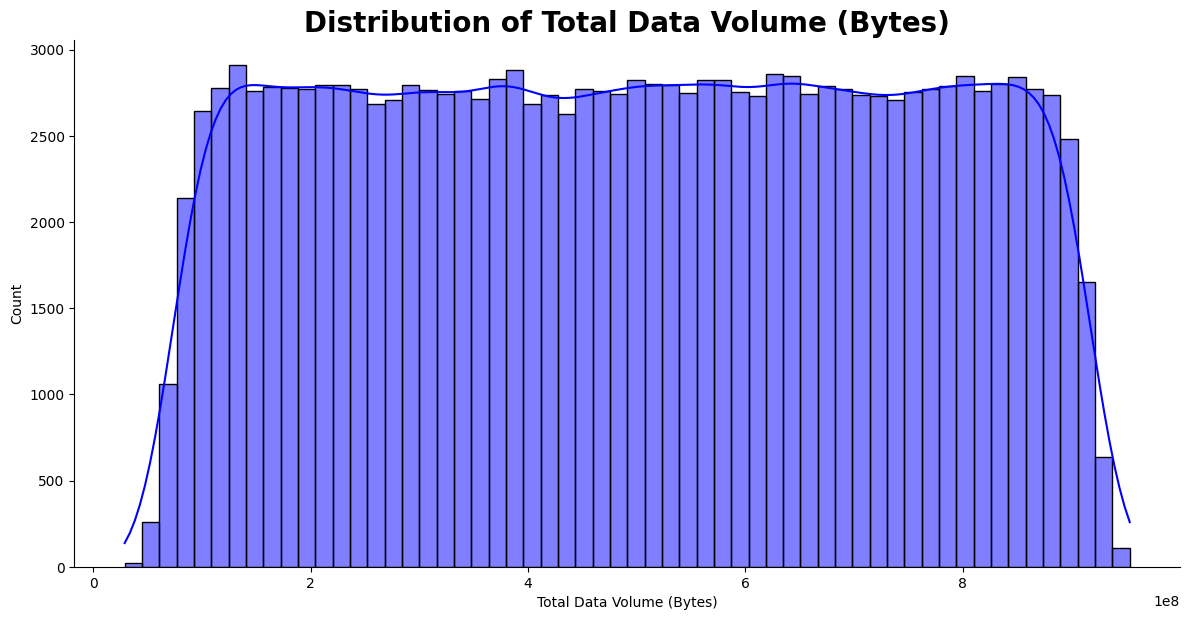

In [56]:
plot_hist(df_clean, 'Total Data Volume (Bytes)', 'blue')

### Bivariate Analysis

Social media UL + DL and Total Data Volume

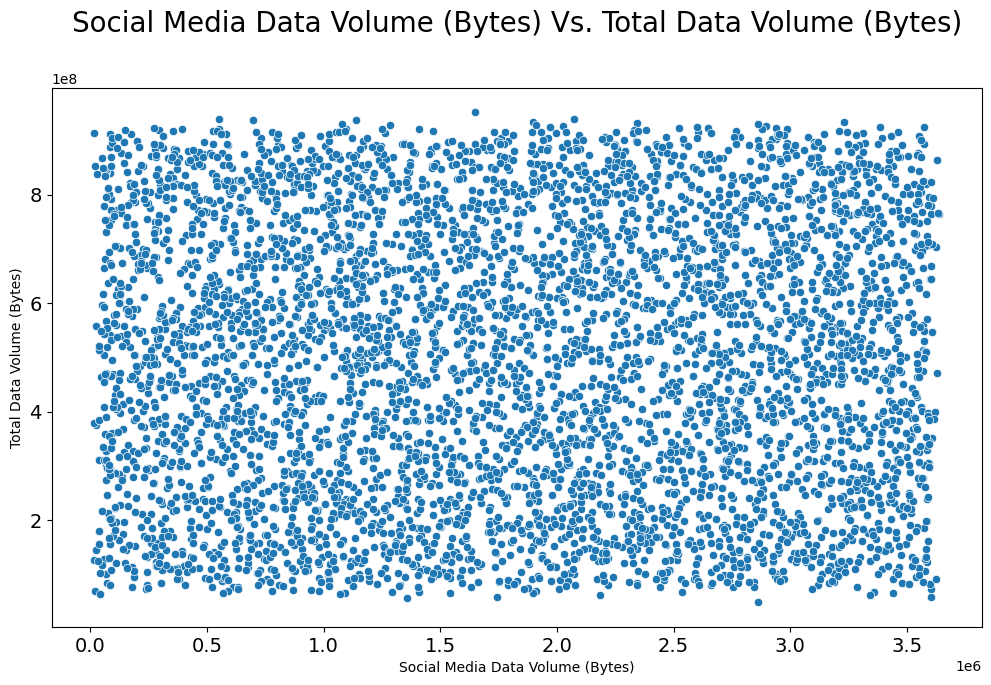

In [58]:
df_clean['Social Media Data Volume (Bytes)'] = df_clean['Social Media UL (Bytes)'] + df_clean['Social Media DL (Bytes)']
plot_scatter(df_clean.sample(5000), 'Social Media Data Volume (Bytes)', 'Total Data Volume (Bytes)')

Google UL + DL and Total Data Volume 

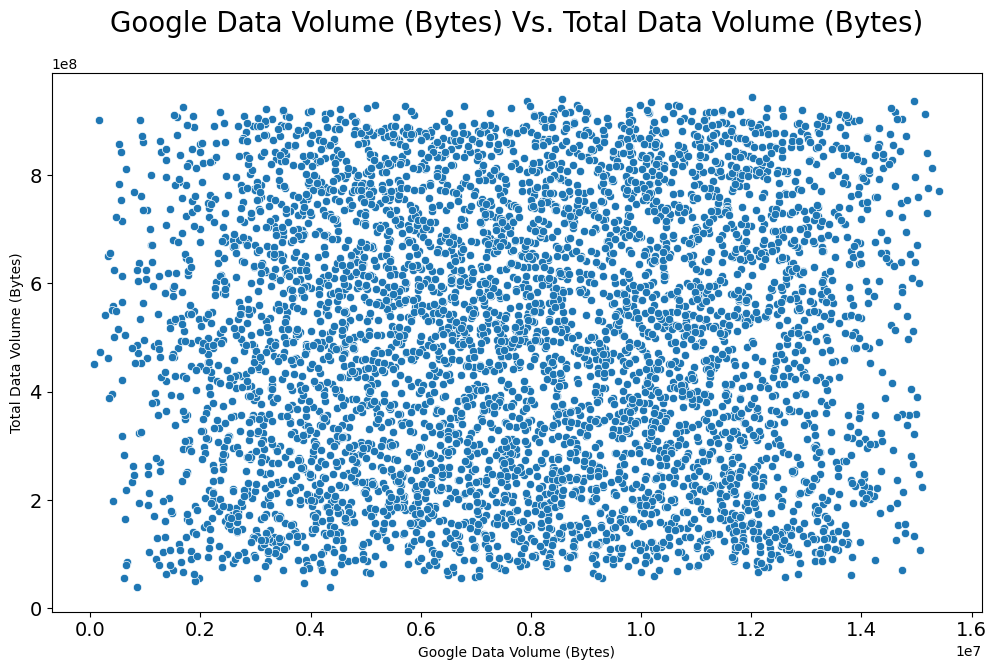

In [59]:
df_clean['Google Data Volume (Bytes)'] = df_clean['Google UL (Bytes)'] + df_clean['Google DL (Bytes)']
plot_scatter(df_clean.sample(5000), 'Google Data Volume (Bytes)', 'Total Data Volume (Bytes)')

Email UL + DL and Total Data Volume

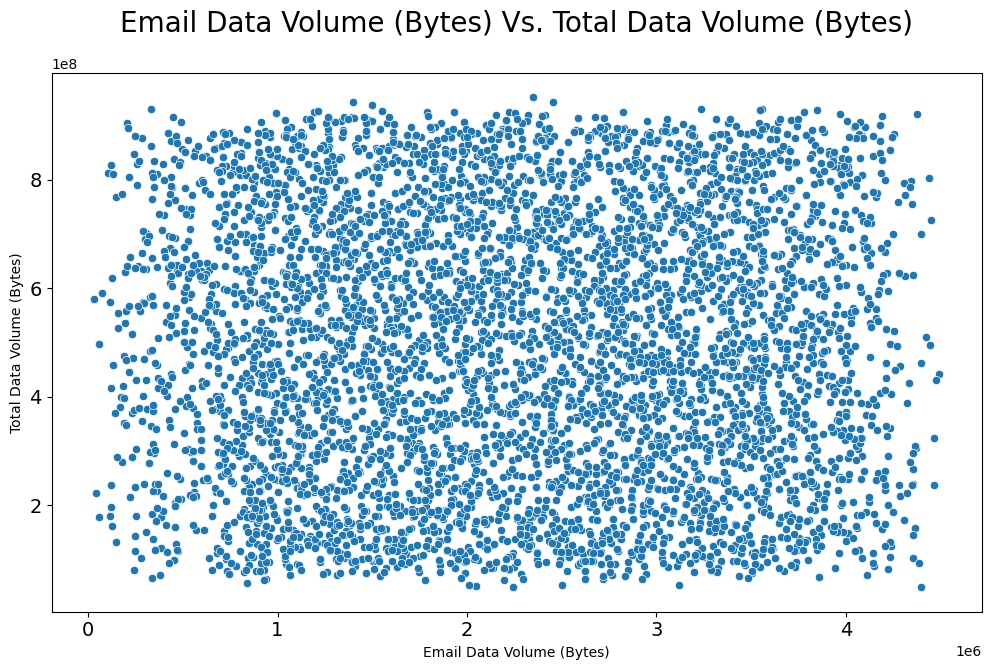

In [61]:
#email,netflix,other
df_clean['Email Data Volume (Bytes)'] = df_clean['Email UL (Bytes)'] + df_clean['Email DL (Bytes)']
plot_scatter(df_clean.sample(5000), 'Email Data Volume (Bytes)', 'Total Data Volume (Bytes)')

Youtube UL + DL and Total Data Volume

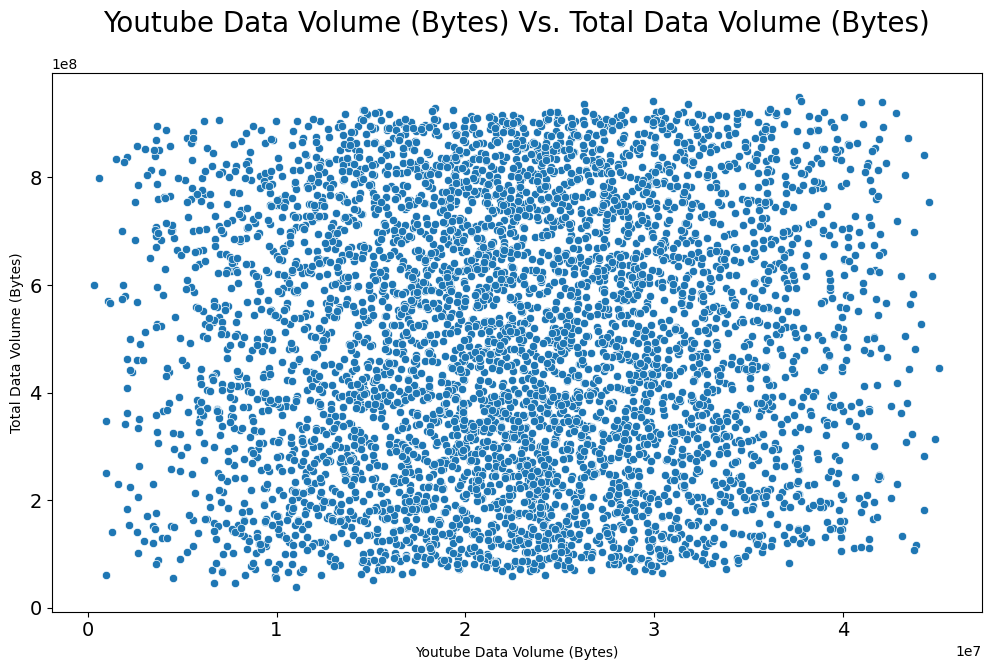

In [62]:
df_clean['Youtube Data Volume (Bytes)'] = df_clean['Youtube UL (Bytes)'] + df_clean['Youtube DL (Bytes)']
plot_scatter(df_clean.sample(5000), 'Youtube Data Volume (Bytes)', 'Total Data Volume (Bytes)')

Netflix UL + DL and Total Data Volume

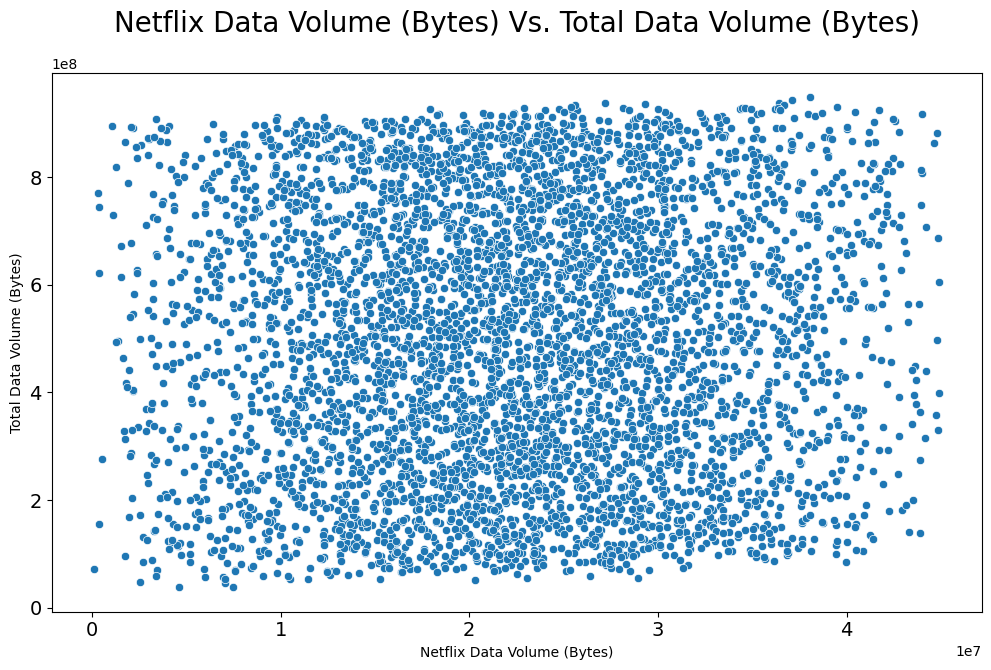

In [63]:
df_clean['Netflix Data Volume (Bytes)'] = df_clean['Netflix UL (Bytes)'] + df_clean['Netflix DL (Bytes)']
plot_scatter(df_clean.sample(5000), 'Netflix Data Volume (Bytes)', 'Total Data Volume (Bytes)')

Other UL + DL and Total Data Volume

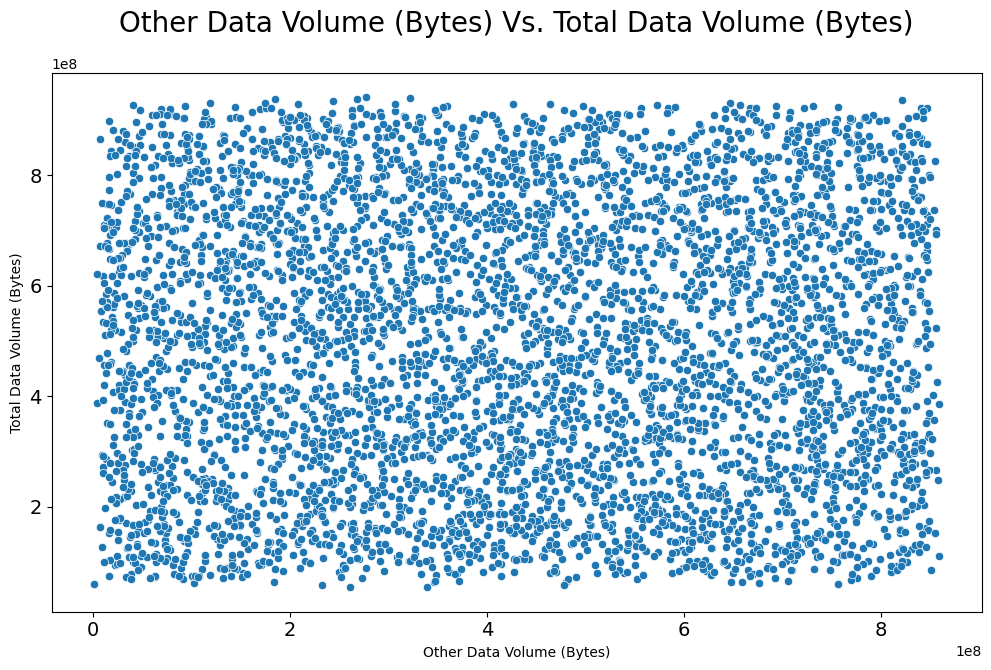

In [64]:
df_clean['Other Data Volume (Bytes)'] = df_clean['Other UL (Bytes)'] + df_clean['Other DL (Bytes)']
plot_scatter(df_clean.sample(5000), 'Other Data Volume (Bytes)', 'Total Data Volume (Bytes)')